In [329]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import math
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OneHotEncoder

Preprocessing

In [330]:
with open('spambase/spambase.data') as f:
    raw_data = f.readlines()

In [331]:
data_arr = np.array([row.strip('\n').split(',') for row in raw_data]).astype('float')

In [332]:
data_arr

array([[0.000e+00, 6.400e-01, 6.400e-01, ..., 6.100e+01, 2.780e+02,
        1.000e+00],
       [2.100e-01, 2.800e-01, 5.000e-01, ..., 1.010e+02, 1.028e+03,
        1.000e+00],
       [6.000e-02, 0.000e+00, 7.100e-01, ..., 4.850e+02, 2.259e+03,
        1.000e+00],
       ...,
       [3.000e-01, 0.000e+00, 3.000e-01, ..., 6.000e+00, 1.180e+02,
        0.000e+00],
       [9.600e-01, 0.000e+00, 0.000e+00, ..., 5.000e+00, 7.800e+01,
        0.000e+00],
       [0.000e+00, 0.000e+00, 6.500e-01, ..., 5.000e+00, 4.000e+01,
        0.000e+00]])

In [333]:
X = data_arr[:,:-1]
y = data_arr[:,-1]

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [335]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [336]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Problem 1

In [337]:
clf = DecisionTreeClassifier(random_state=0, criterion='entropy')

In [338]:
clf = clf.fit(X_train, y_train)

In [339]:
def four_metrics_auc(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp + tn)/(tn+fp+fn+tp)
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1 = (2 * precision * recall)/(precision + recall)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    
    return acc, precision, recall, f1, auc

In [340]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [341]:
df = pd.DataFrame(columns=['Criterion', 'Data', 'Accuracy', 'Error', 'F1 score', 'AUC']) 

acc, _, _, f1, auc = four_metrics_auc(y_train, y_train_pred)
df_new_row = pd.DataFrame.from_records([{'Criterion': 'entropy', 'Data': 'Train', 'Accuracy':acc, 'Error': 1- acc, 'F1 score': f1, 'AUC': auc}])
df = pd.concat([df, df_new_row], sort=False, ignore_index=True)


acc, _, _, f1, auc = four_metrics_auc(y_test, y_test_pred)
df_new_row = pd.DataFrame.from_records([{'Criterion': 'entropy', 'Data': 'Test', 'Accuracy':acc, 'Error': 1- acc, 'F1 score': f1, 'AUC': auc}])
df = pd.concat([df, df_new_row], sort=False, ignore_index=True)

In [342]:
clf2 = DecisionTreeClassifier(random_state=0, criterion='gini')
clf2 = clf2.fit(X_train, y_train)

In [343]:
y_train_pred = clf2.predict(X_train)
y_test_pred = clf2.predict(X_test)

In [344]:
acc, _, _, f1, auc = four_metrics_auc(y_train, y_train_pred)
df_new_row = pd.DataFrame.from_records([{'Criterion': 'gini', 'Data': 'Train', 'Accuracy':acc, 'Error': 1- acc, 'F1 score': f1, 'AUC': auc}])
df = pd.concat([df, df_new_row], sort=False, ignore_index=True)


acc, _, _, f1, auc = four_metrics_auc(y_test, y_test_pred)
df_new_row = pd.DataFrame.from_records([{'Criterion': 'gini', 'Data': 'Test', 'Accuracy':acc, 'Error': 1- acc, 'F1 score': f1, 'AUC': auc}])
df = pd.concat([df, df_new_row], sort=False, ignore_index=True)

In [345]:
df

,Criterion,Data,Accuracy,Error,F1 score,AUC
0,entropy,Train,0.999420,0.000580,0.999252,0.999253
1,entropy,Test,0.915725,0.084275,0.896478,0.911040
2,gini,Train,0.999420,0.000580,0.999252,0.999253
3,gini,Test,0.913119,0.086881,0.894958,0.910699


In [346]:
train_errs = []
test_errs = []
depths = range(1, 30)

for tree_depth in depths:
    clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=tree_depth)
    clf = clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    acc, _, _, _, _ = four_metrics_auc(y_train, y_train_pred)
    train_errs.append(1-acc)
    
    acc, _, _, _, _ = four_metrics_auc(y_test, y_test_pred)
    test_errs.append(1-acc)

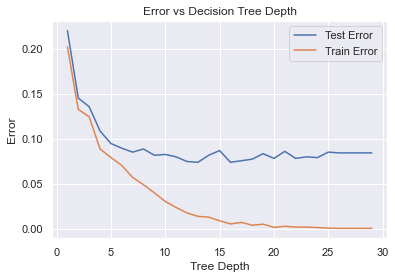

In [347]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.plot(depths, test_errs, label='Test Error')
plt.plot(depths, train_errs, label='Train Error')
plt.title('Error vs Decision Tree Depth')
plt.ylabel('Error')
plt.xlabel('Tree Depth')
plt.legend()

## Problem 2

In [348]:
T = [10, 50, 100, 500]
df = pd.DataFrame(columns=['Data', 'Trees', 'Accuracy', 'F1 score', 'AUC'])

for num_trees in T:
    clf = RandomForestClassifier(n_estimators=num_trees, max_depth=None, criterion='entropy', random_state=0)
    clf = clf.fit(X_train, y_train)
    
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    acc, _, _, f1, auc = four_metrics_auc(y_train, y_train_pred)
    df_new_row = pd.DataFrame.from_records([{'Data': 'Train', 'Trees': num_trees, 'Accuracy': acc, 'F1 score': f1, 'AUC': auc}])
    df = pd.concat([df, df_new_row], sort=False, ignore_index=True)
    
    acc, _, _, f1, auc = four_metrics_auc(y_test, y_test_pred)
    df_new_row = pd.DataFrame.from_records([{'Data': 'Test', 'Trees': num_trees, 'Accuracy': acc, 'F1 score': f1, 'AUC': auc}])
    df = pd.concat([df, df_new_row], sort=False, ignore_index=True)
    
    

In [349]:
df

,Data,Trees,Accuracy,F1 score,AUC
0,Train,10,0.998841,0.998504,0.998642
1,Test,10,0.953084,0.941048,0.946288
2,Train,50,0.999420,0.999253,0.999390
3,Test,50,0.955691,0.944865,0.950385
4,Train,100,0.999420,0.999253,0.999390
5,Test,100,0.957428,0.947027,0.952177
6,Train,500,0.999420,0.999253,0.999390
7,Test,500,0.958297,0.948276,0.953543


In [350]:
clf = RandomForestClassifier(n_estimators=500, max_depth=10, criterion='entropy', random_state=0)
clf = clf.fit(X_train, y_train)

In [351]:
clf.feature_importances_

array([0.00301627, 0.00501643, 0.00997358, 0.00046294, 0.0299485 ,
       0.00530804, 0.10022875, 0.01309559, 0.0045031 , 0.00542419,
       0.00584445, 0.00930408, 0.00249842, 0.00134294, 0.00170004,
       0.06742312, 0.01295322, 0.00628319, 0.02174187, 0.00549139,
       0.05667644, 0.00102362, 0.02520076, 0.03671297, 0.0542579 ,
       0.02417809, 0.03433415, 0.00458865, 0.0025518 , 0.00511863,
       0.00174508, 0.00062819, 0.00240695, 0.00056513, 0.00424596,
       0.00204062, 0.01628157, 0.00023652, 0.00220276, 0.00106835,
       0.00093277, 0.00465972, 0.00149477, 0.00244187, 0.00978965,
       0.01680476, 0.00011398, 0.00103565, 0.00326371, 0.00925005,
       0.00252175, 0.10878314, 0.09572775, 0.00256857, 0.05915515,
       0.05771832, 0.03611416])

In [352]:
np.flip(np.sort(clf.feature_importances_))

array([0.10878314, 0.10022875, 0.09572775, 0.06742312, 0.05915515,
       0.05771832, 0.05667644, 0.0542579 , 0.03671297, 0.03611416,
       0.03433415, 0.0299485 , 0.02520076, 0.02417809, 0.02174187,
       0.01680476, 0.01628157, 0.01309559, 0.01295322, 0.00997358,
       0.00978965, 0.00930408, 0.00925005, 0.00628319, 0.00584445,
       0.00549139, 0.00542419, 0.00530804, 0.00511863, 0.00501643,
       0.00465972, 0.00458865, 0.0045031 , 0.00424596, 0.00326371,
       0.00301627, 0.00256857, 0.0025518 , 0.00252175, 0.00249842,
       0.00244187, 0.00240695, 0.00220276, 0.00204062, 0.00174508,
       0.00170004, 0.00149477, 0.00134294, 0.00106835, 0.00103565,
       0.00102362, 0.00093277, 0.00062819, 0.00056513, 0.00046294,
       0.00023652, 0.00011398])

In [353]:
np.flip(np.argsort(clf.feature_importances_))

array([51,  6, 52, 15, 54, 55, 20, 24, 23, 56, 26,  4, 22, 25, 18, 45, 36,
        7, 16,  2, 44, 11, 49, 17, 10, 19,  9,  5, 29,  1, 41, 27,  8, 34,
       48,  0, 53, 28, 50, 12, 43, 32, 38, 35, 30, 14, 42, 13, 39, 47, 21,
       40, 31, 33,  3, 37, 46])

Text(0.5, 0, 'Importance')

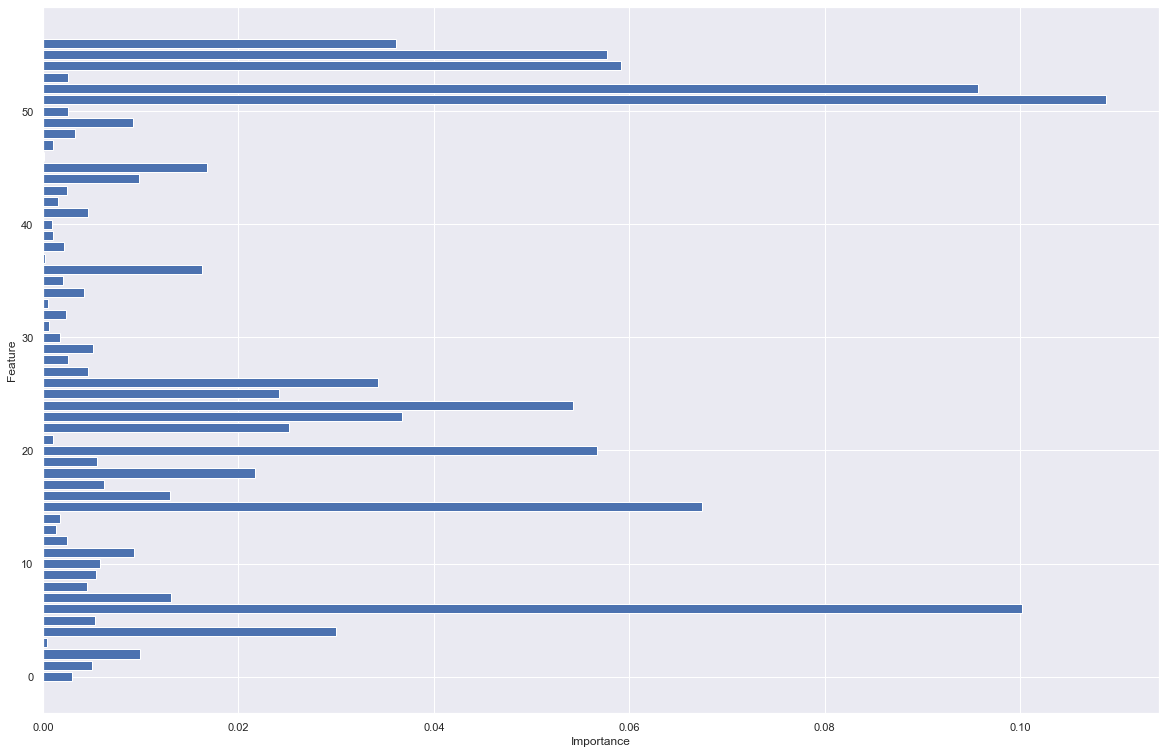

In [354]:
plt.barh(np.flip(np.argsort(clf.feature_importances_)), np.flip(np.sort(clf.feature_importances_)))
plt.gcf().set_size_inches(20, 13)
plt.ylabel('Feature')
plt.xlabel('Importance')

## Problem 3

In [355]:
T = [10, 50, 100, 500]
df = pd.DataFrame(columns=['Data', 'Classifiers', 'Accuracy', 'F1 score', 'AUC'])

for num_classifiers in T:
    clf = AdaBoostClassifier(n_estimators=num_classifiers, random_state=0)
    clf = clf.fit(X_train, y_train)
    
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    acc, _, _, f1, auc = four_metrics_auc(y_train, y_train_pred)
    df_new_row = pd.DataFrame.from_records([{'Data': 'Train', 'Classifiers': num_classifiers, 'Accuracy': acc, 'F1 score': f1, 'AUC': auc}])
    df = pd.concat([df, df_new_row], sort=False, ignore_index=True)
    
    acc, _, _, f1, auc = four_metrics_auc(y_test, y_test_pred)
    df_new_row = pd.DataFrame.from_records([{'Data': 'Test', 'Classifiers': num_classifiers, 'Accuracy': acc, 'F1 score': f1, 'AUC': auc}])
    df = pd.concat([df, df_new_row], sort=False, ignore_index=True)
    
    

In [356]:
df

,Data,Classifiers,Accuracy,F1 score,AUC
0,Train,10,0.923768,0.900190,0.916920
1,Test,10,0.922676,0.902944,0.915079
2,Train,50,0.946667,0.930775,0.942607
3,Test,50,0.934839,0.919614,0.930129
4,Train,100,0.957391,0.944799,0.954243
5,Test,100,0.943527,0.931217,0.940969
6,Train,500,0.989855,0.986896,0.988975
7,Test,500,0.937446,0.924211,0.935478


In [357]:
clf_dt = DecisionTreeClassifier(random_state=0, criterion='entropy')
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=None, criterion='entropy', random_state=0)
clf_ab = AdaBoostClassifier(n_estimators=100, random_state=0)

clf_dt = clf_dt.fit(X_train, y_train)
clf_rf = clf_rf.fit(X_train, y_train)
clf_ab = clf_ab.fit(X_train, y_train)

Text(0.5, 1.0, 'AdaBoost ROC')

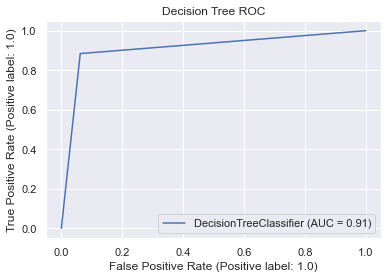

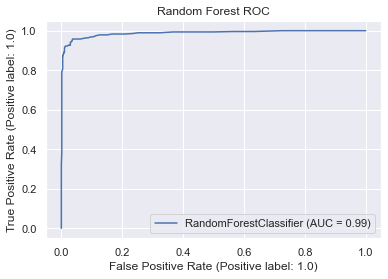

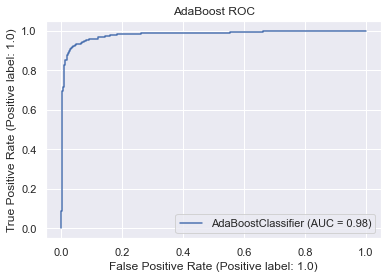

In [358]:
metrics.plot_roc_curve(clf_dt, X_test, y_test) 
plt.title('Decision Tree ROC')

metrics.plot_roc_curve(clf_rf, X_test, y_test) 
plt.title('Random Forest ROC')

metrics.plot_roc_curve(clf_ab, X_test, y_test) 
plt.title('AdaBoost ROC')

## Problem 4 

In [359]:
with open('mushroom/agaricus-lepiota.data') as f:
    raw_data = f.readlines()

In [360]:
data_arr = np.array([row.strip('\n').split(',') for row in raw_data])

In [361]:
X = data_arr[:,1:]
y = data_arr[:,0]

In [362]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [363]:
#classifier
class NaiveBayesClassifier:
    #params: training data, training labels
    def __init__(self, X_train, y_train):
        
        #get classes and counts of classes 
        classes, counts = np.unique(y_train, return_counts=True)
        
        #store classes
        self.classes = classes
        
        #store priors
        self.priors = []
        
        #for each label, calculate prior and store in self.priors
        for i, label in enumerate(classes):
            label_prior = counts[i]/sum(counts)
            self.priors.append(label_prior)
            
        #store conditional probabilities for each label
        self.conditionals = dict()
        
        #for each label
        for label in self.classes:
            #track the current label's conditional probabilities
            label_conditionals = []
            
            #for each feature
            for feature in range(X_train.shape[-1]):
                
                #get current feature value from all samples
                samples = X_train[:, feature]
                
                #get attributes of current feature
                attributes = np.unique(samples)
                
                #get samples that have the current label
                label_samples = [sample for i, sample in enumerate(samples) if y_train[i] == label]
                
                #get count for each attribute of current feature
                attribute_counts = []
                for attribute in attributes:
                    attribute_counts.append(label_samples.count(attribute))
        
                #track conditional probabilities for current feature
                label_feature_dict = dict()
                
                #for each attribute, calculate conditional probability, use Laplace smoothing
                for i, attribute in enumerate(attributes):
                    label_feature_dict[attribute] = (attribute_counts[i] + 1)/(sum(attribute_counts) + len(attributes))
                
                #store conditional probabilities for current feature
                label_conditionals.append(label_feature_dict)
            
            #store conditional probabilities for current label
            self.conditionals[label] = label_conditionals
            
    def predict_one(self, x_test, output_probs=False):
        
        #track probabilities of label given testing data
        probs = []
        
        #for each label
        for label_idx, label in enumerate(self.classes):
            
            #get prior
            prob = self.priors[label_idx]
            
            #for each feature
            for feature_idx, attribute in enumerate(x_test):
                
                #multiply by conditional
                prob *= self.conditionals[label][feature_idx][attribute]
            
            #store probability of current label given testing data
            probs.append(prob)
        
        #return class k that maximizes prob or just the probabilities
        return probs if output_probs else self.classes[np.argmax(np.array(probs))]
    
    def predict(self, X_test, output_probs=False):
        predictions = []
        
        #for every testing sample
        for x_test in X_test:
            if output_probs:
                predictions.append(self.predict_one(x_test, output_probs=True))
            else:
                predictions.append(self.predict_one(x_test))
            
        return np.array(predictions)
                

In [364]:
clf = NaiveBayesClassifier(X_train, y_train)

In [365]:
clf.predict(X_test, output_probs=True)

array([[2.14385322e-09, 1.54054719e-14],
       [7.24757595e-18, 3.87359380e-08],
       [4.38518866e-18, 4.88793955e-07],
       ...,
       [7.44143337e-09, 7.28526888e-17],
       [1.40249140e-11, 2.50197435e-18],
       [7.45607702e-18, 1.80972477e-07]])

In [366]:
def four_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp + tn)/(tn+fp+fn+tp)
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1 = (2 * precision * recall)/(precision + recall)
    
    return acc, precision, recall, f1

In [367]:
acc, precision, recall, f1 = four_metrics(y_test, clf.predict(X_test))
print(f'Accuracy: {acc}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1}')

Accuracy: 0.9487936976858691
Precision: 0.9900552486187846
Recall: 0.9041372351160444
F1 score: 0.9451476793248945


In [368]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train)
ohe.fit(X_test)
X_train_ohe = ohe.transform(X_train).toarray()
X_test_ohe = ohe.transform(X_test).toarray()

In [369]:
clf = CategoricalNB()
clf = clf.fit(X_train_ohe, y_train)
y_pred = clf.predict(X_test_ohe)

In [370]:
acc, precision, recall, f1 = four_metrics(y_test, clf.predict(X_test_ohe))
print(f'Accuracy: {acc}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1}')

Accuracy: 0.9369768586903003
Precision: 0.982122905027933
Recall: 0.8869828456104945
F1 score: 0.9321314952279959
